<a href="https://colab.research.google.com/github/Koel09/DS_Classification_GymAttendance/blob/main/GymAttendance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install imblearn
# Import necessary libraries
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()

Saving fitness_class_2212.csv to fitness_class_2212.csv


In [3]:
# Load the dataset
df = pd.read_csv('fitness_class_2212.csv')  # Replace with your file path

# Display dataset info
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
df.head()

Dataset Shape: (1500, 8)

First 5 Rows:


,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
0,1,17,79.56,8,Wed,PM,Strength,0
1,2,10,79.01,2,Mon,AM,HIIT,0
2,3,16,74.53,14,Sun,AM,Strength,0
3,4,5,86.12,10,Fri,AM,Cycling,0
4,5,15,69.29,8,Thu,AM,HIIT,0


In [4]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
booking_id           0
months_as_member     0
weight              20
days_before          0
day_of_week          0
time                 0
category             0
attended             0
dtype: int64


In [5]:
# # days_before column has string values
# # days_of_week column has inconsistent values
df['days_before'] = df['days_before'].str.replace(' days', '', regex=True)
df = df.astype({"days_before": int})
df['day_of_week'] = df['day_of_week'].str.slice(0, 3)

# df.info()

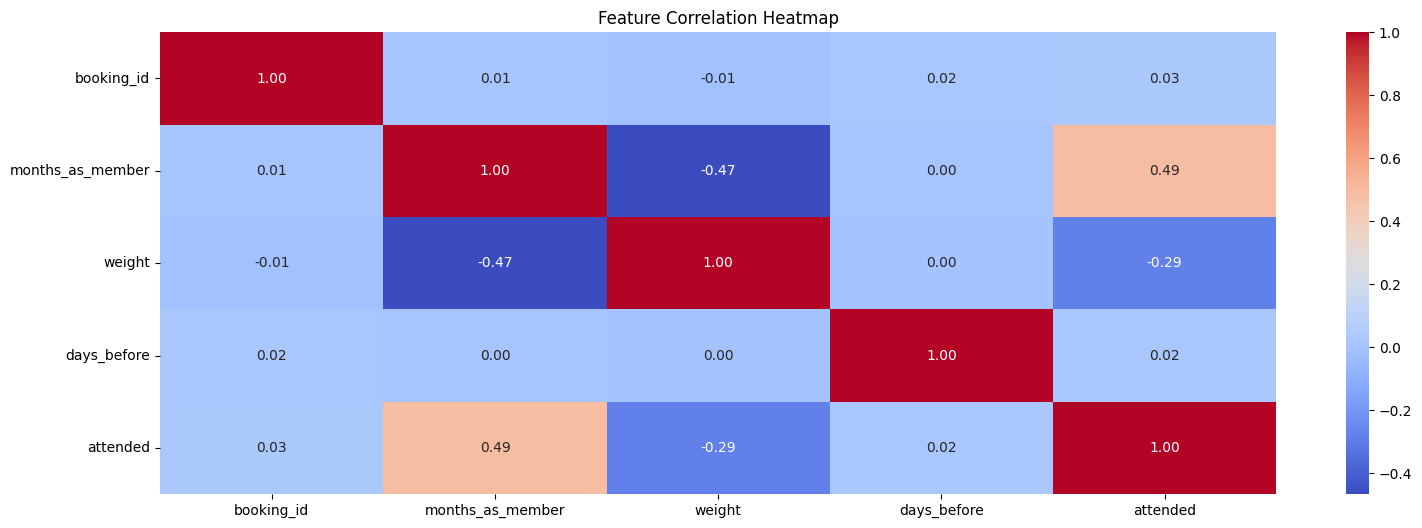

In [6]:
# Correlation heatmap
plt.figure(figsize=(18, 6))

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Create heatmap with only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

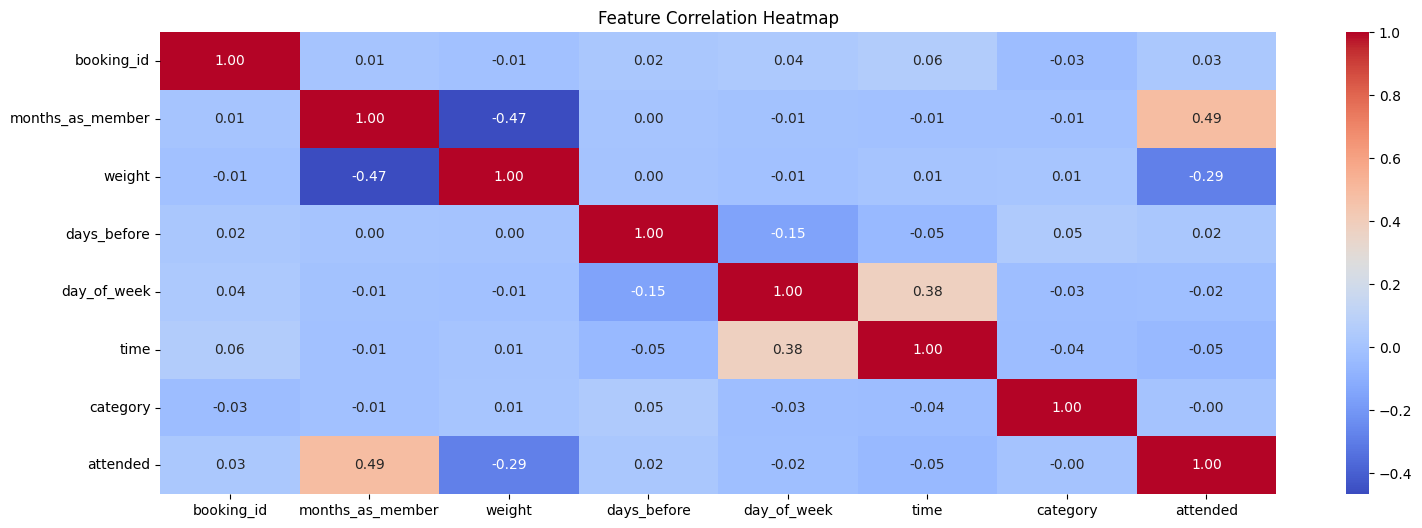

In [7]:
# Preprocessing
# Encode categorical variables using label encoding, feel free to try one-hot encoding
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
#check encoded classes
# pd.unique(df['day_of_week'])

# Correlation heatmap
plt.figure(figsize=(18, 6))
# Create heatmap with only numeric columns
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

In [8]:
# Handle missing values
# Option 1: Drop rows with missing values
# df = df.dropna()

# Option 2: Impute missing values (uncomment below if you prefer imputation)
imputer = SimpleImputer(strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [9]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

df.info()


Missing Values:
booking_id          0
months_as_member    0
weight              0
days_before         0
day_of_week         0
time                0
category            0
attended            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1500 non-null   float64
 1   months_as_member  1500 non-null   float64
 2   weight            1500 non-null   float64
 3   days_before       1500 non-null   float64
 4   day_of_week       1500 non-null   float64
 5   time              1500 non-null   float64
 6   category          1500 non-null   float64
 7   attended          1500 non-null   float64
dtypes: float64(8)
memory usage: 93.9 KB


In [10]:
df.describe()

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,750.500000,15.628667,82.610378,8.346667,2.604000,0.239333,2.957333,0.302667
std,433.157015,12.926543,12.680411,4.077938,1.948088,0.426819,1.022518,0.459565
min,1.000000,1.000000,55.410000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,375.750000,8.000000,73.562500,4.000000,1.000000,0.000000,2.000000,0.000000
50%,750.500000,12.000000,81.035000,9.000000,3.000000,0.000000,3.000000,0.000000
75%,1125.250000,19.000000,89.382500,12.000000,4.000000,0.000000,3.000000,1.000000
max,1500.000000,148.000000,170.520000,29.000000,6.000000,1.000000,5.000000,1.000000


In [11]:
# # Boxplot to detect outliers
# plt.figure(figsize=(18, 6))
# #to plot all the scatterplots in a single plot
# sns.pairplot(df, x_vars=['weight','months_as_member'], y_vars = 'attended', height = 4, kind = 'scatter' )
# plt.show()

# Label is not related to any feature. How a model find a pattern without any correlation?

In [12]:
#check for dataset imbalance
print('number of samples in each class:')
df['attended'].value_counts()

number of samples in each class:


,count
attended,
0.0,1046
1.0,454


In [13]:
# Split features and target
X = df.drop('attended', axis=1)  # Replace 'Attendance' with your target column name
y = df['attended']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
#Balancing the Dataset (SMOTE: Oversampling using imblearn library)
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

In [16]:
# Model Evaluation Metrics
def evaluate_model(y_true, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

In [17]:
#Logistic Regression
lr_balanced = LogisticRegression(random_state=42)
lr_balanced.fit(X_train, y_train)
y_pred_lr_balanced = lr_balanced.predict(X_test)

evaluate_model(y_test, y_pred_lr_balanced)

# why used impbalanced test data to predict y_pred_lr_balanced in the tutorial code?
# when to use Mean Squared Error,R-squared Score,Log Loss,ROC AUC Score (ovr) metrics?
# How to choose parameters grid values for tuning?

Confusion Matrix:
[[245  56]
 [104 223]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.81      0.75       301
         1.0       0.80      0.68      0.74       327

    accuracy                           0.75       628
   macro avg       0.75      0.75      0.74       628
weighted avg       0.75      0.75      0.74       628



In [18]:
#Hyperparameter Tuning (Logistic Regression)
param_grid_lr = {
    'C': [0.1, 1.0, 10.0],  # Regularization parameter
    'penalty': ['l1', 'l2', 'elasticnet',None],  # Regularization type
    'solver': ['lbfgs','liblinear', 'saga'],  # Algorithm to use
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

# Note: If using 'elasticnet' penalty, you need 'saga' solver and specify l1_ratio
# For 'l1' penalty, only 'liblinear' and 'saga' solvers are supported

grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5)
grid_search_lr.fit(X_train, y_train)

print("\nBest Parameters for Logistic Regression:")
print(grid_search_lr.best_params_)

# Evaluate tuned Logistic Regression
best_lr = grid_search_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test)

evaluate_model(y_test, y_pred_best_lr)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and


Best Parameters for Logistic Regression:
{'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Confusion Matrix:
[[245  56]
 [104 223]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.81      0.75       301
         1.0       0.80      0.68      0.74       327

    accuracy                           0.75       628
   macro avg       0.75      0.75      0.74       628
weighted avg       0.75      0.75      0.74       628



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and

In [19]:
#Random Forest
rf_balanced = RandomForestClassifier(random_state=42)
rf_balanced.fit(X_train, y_train)
y_pred_rf_balanced = rf_balanced.predict(X_test)

evaluate_model(y_test, y_pred_rf_balanced)

Confusion Matrix:
[[254  47]
 [ 61 266]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.82       301
         1.0       0.85      0.81      0.83       327

    accuracy                           0.83       628
   macro avg       0.83      0.83      0.83       628
weighted avg       0.83      0.83      0.83       628



In [20]:
#Hyperparameter Tuning (Random Forest)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)

print("\nBest Parameters for Random Forest:")
print(grid_search_rf.best_params_)

# Evaluate tuned Random Forest
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

evaluate_model(y_test, y_pred_best_rf)


Best Parameters for Random Forest:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Confusion Matrix:
[[255  46]
 [ 62 265]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.83       301
         1.0       0.85      0.81      0.83       327

    accuracy                           0.83       628
   macro avg       0.83      0.83      0.83       628
weighted avg       0.83      0.83      0.83       628



In [21]:
#Gradient Boosting Trees (GBT)
gbt = GradientBoostingClassifier(random_state=42)
gbt.fit(X_train, y_train)
y_pred_gbt = gbt.predict(X_test)

evaluate_model(y_test, y_pred_gbt)

Confusion Matrix:
[[243  58]
 [ 58 269]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81       301
         1.0       0.82      0.82      0.82       327

    accuracy                           0.82       628
   macro avg       0.81      0.81      0.81       628
weighted avg       0.82      0.82      0.82       628



In [22]:
#Hyperparameter Tuning (Gradient boosting)
from sklearn.ensemble import GradientBoostingClassifier  # Import the correct class
from sklearn.model_selection import GridSearchCV

# Parameters specific to GradientBoostingClassifier
param_grid_gb = {
    'n_estimators': [100, 200],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'max_depth': [3, 5, 7],  # Maximum depth of individual trees
    'min_samples_split': [2, 5],  # Minimum samples required to split a node
    'subsample': [0.8, 1.0]  # Fraction of samples for fitting individual trees
}

grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5)
grid_search_gb.fit(X_train, y_train)

print("\nBest Parameters for Gradient boosting:")
print(grid_search_gb.best_params_)

# Evaluate tuned Gradient Boosting
best_gb = grid_search_gb.best_estimator_
y_pred_best_gb = best_gb.predict(X_test)

evaluate_model(y_test, y_pred_best_gb)


Best Parameters for Gradient boosting:
{'learning_rate': 0.2, 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 1.0}
Confusion Matrix:
[[249  52]
 [ 61 266]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.83      0.82       301
         1.0       0.84      0.81      0.82       327

    accuracy                           0.82       628
   macro avg       0.82      0.82      0.82       628
weighted avg       0.82      0.82      0.82       628



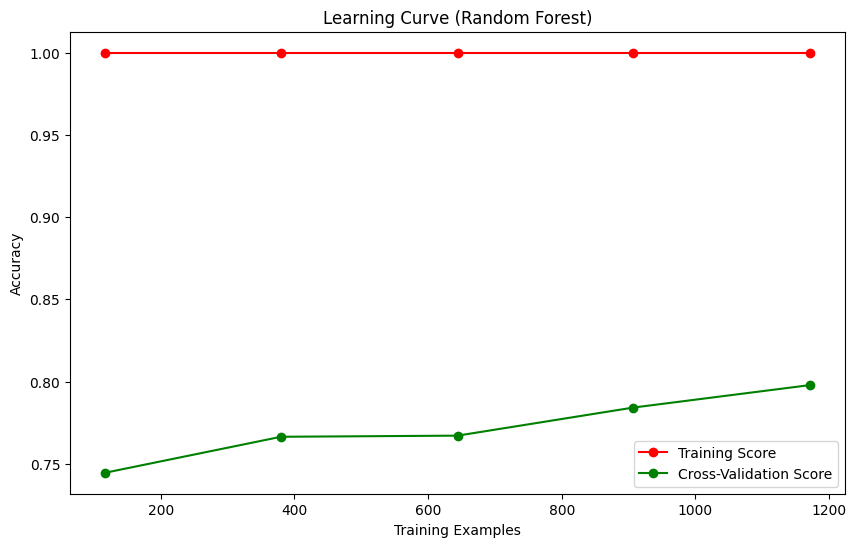

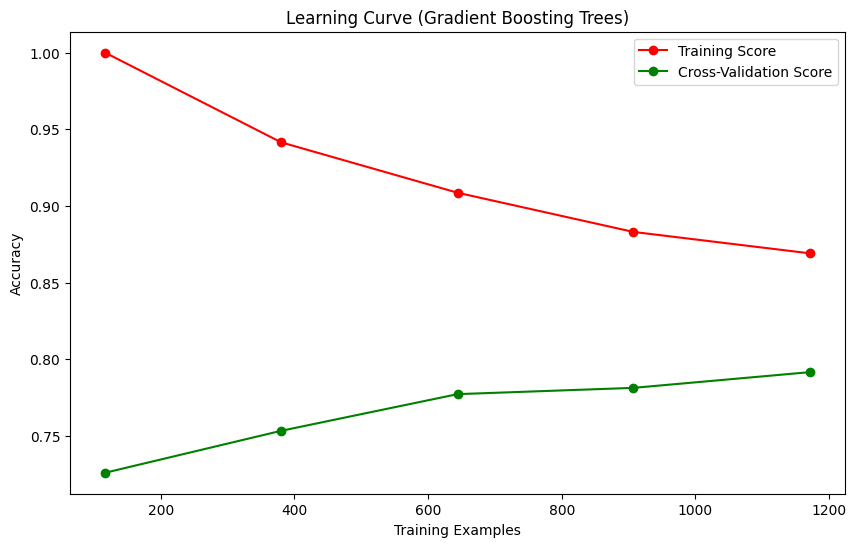

In [23]:
#Bias-Variance Tradeoff (Learning Curves)
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend(loc="best")
    plt.show()

# Plot learning curve for Random Forest
plot_learning_curve(best_rf, "Learning Curve (Random Forest)", X_train, y_train)

# Plot learning curve for Gradient Boosting Trees
plot_learning_curve(gbt, "Learning Curve (Gradient Boosting Trees)", X_train, y_train)

In [24]:
# Model Comparison
models = {
    'Logistic Regression': lr_balanced,
    'Logistic Regression (Tuned)': best_lr,
    'Random Forest': rf_balanced,
    'Random Forest (Tuned)': best_rf,
    'Gradient Boosting': gbt,
    'Gradient Boosting (Tuned)': best_gb,
}

metrics = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    metrics.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    })

metrics_df = pd.DataFrame(metrics)
print("\nModel Comparison:")
metrics_df


Model Comparison:


,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.745223,0.799283,0.681957,0.735974
1,Logistic Regression (Tuned),0.745223,0.799283,0.681957,0.735974
2,Random Forest,0.828025,0.849840,0.813456,0.831250
3,Random Forest (Tuned),0.828025,0.852090,0.810398,0.830721
4,Gradient Boosting,0.815287,0.822630,0.822630,0.822630
5,Gradient Boosting (Tuned),0.820064,0.836478,0.813456,0.824806


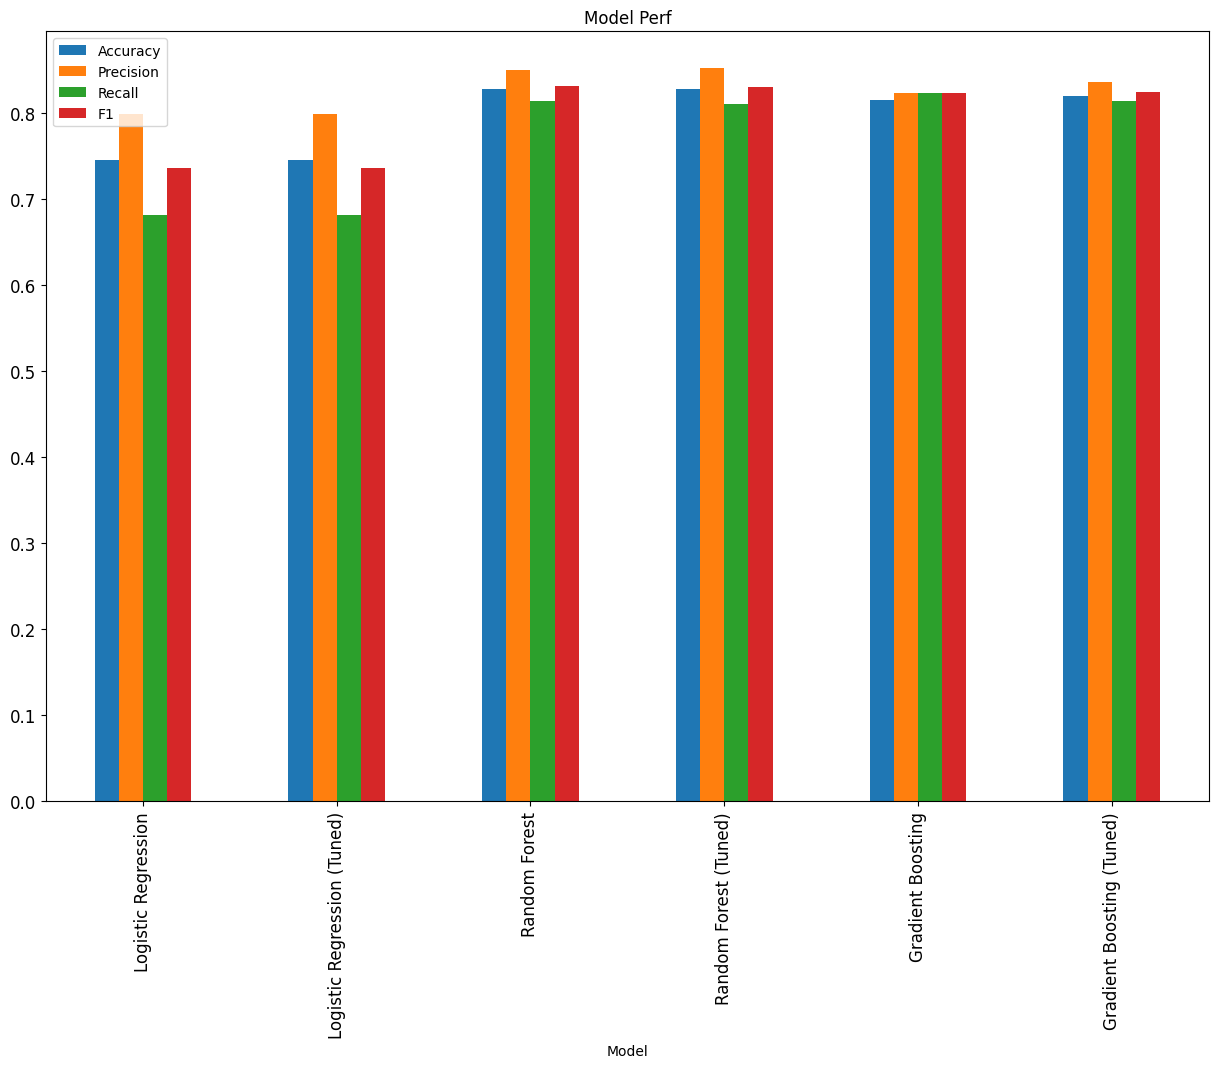

In [25]:
metrics_bar = metrics_df.plot(x='Model', y= ['Accuracy','Precision','Recall','F1'],kind='bar', title ="Model Perf",
                              figsize=(15, 10),xlabel='Model', legend=True, fontsize=12)
plt.show()

In [26]:
#Cross-Validation
def cross_validation(model,X,y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print("\nCross-Validation Scores:", cv_scores)
    print("Mean CV Accuracy:", cv_scores.mean())


In [27]:
print("Logistic Regression")
cross_validation(lr_balanced, X_train, y_train)

print("\nLogistic Regression (Tuned)")
cross_validation(best_lr, X_train, y_train)

print("\nRandom Forest")
cross_validation(rf_balanced, X_train, y_train)

print("\nRandom Forest (Tuned)")
cross_validation(best_rf, X_train, y_train)

print("\nGradient Boosting")
cross_validation(gbt, X_train, y_train)

print("\nGradient Boosting (Tuned)")
cross_validation(best_gb, X_train, y_train)

Logistic Regression

Cross-Validation Scores: [0.7440273  0.77133106 0.75767918 0.68259386 0.71575342]
Mean CV Accuracy: 0.734276964794988

Logistic Regression (Tuned)

Cross-Validation Scores: [0.76109215 0.778157   0.76109215 0.70307167 0.72945205]
Mean CV Accuracy: 0.7465730048155594

Random Forest

Cross-Validation Scores: [0.778157   0.82935154 0.83276451 0.72354949 0.80136986]
Mean CV Accuracy: 0.7930384777221937

Random Forest (Tuned)

Cross-Validation Scores: [0.78156997 0.83276451 0.83959044 0.74744027 0.80479452]
Mean CV Accuracy: 0.8012319416522512

Gradient Boosting

Cross-Validation Scores: [0.79180887 0.81911263 0.8225256  0.73037543 0.78082192]
Mean CV Accuracy: 0.7889288886810977

Gradient Boosting (Tuned)

Cross-Validation Scores: [0.79522184 0.81228669 0.83276451 0.75767918 0.80479452]
Mean CV Accuracy: 0.8005493477955958
